# **2022 1학기 컴퓨터비전 기말고사** - 스마트생명산업융합학과 22110917 박현지
> ###  **리더보드** : **Learning Spatiotemporal Features with 3D Convolutional Networks**
> ### =>  3D Convolutional Networks 기술을 활용하여 비디오 분류예측
> ###  데이터셋 : UCF-101 (약 6.9GB)
> ####  리더보드 제작자의 베이스라인 코드예시를 참고하였습니다.

## path정보

In [ ]:
class Path(object):
    @staticmethod
    def db_dir(database):
        if database == 'ucf101':
            # folder that contains class labels
            root_dir = '/home/hyeonji/CV_endTerm_C3D/UCF-101'

            # Save preprocess data into output_dir
            output_dir = '/home/hyeonji/CV_endTerm_C3D/ufc101_custom'

            return root_dir, output_dir
        else:
            print('Database {} not available.'.format(database))
            raise NotImplementedError


## Dataset.py

### Dataset의 경우 입력된 영상 리사이즈, 전처리과정, 이후 훈련에 필요한 len, getitem등의 기능이 포함되어있습니다.
> ##### 전처리의 경우 크기조절 및 각 영상을 EXTRACT_FREQUENCY만큼 나누어 캡쳐했을 때, 하나의 영상을 16frame이상이 되도록 하는 과정입니다.
> * 예시로 전체가 16frame영상 => 1frame마다 캡쳐
> * 48frame영상 => 3frame마다 캡쳐
> * 하나의 영상이 최소 16개의 이미지로 축약되도록 함

In [ ]:
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset
#from mypath import Path
from tqdm import tqdm
import pandas as pd


class VideoDataset(Dataset):
    r"""A Dataset for a folder of videos. Expects the directory structure to be
    directory->[train/val/test]->[class labels]->[videos]. Initializes with a list
    of all file names, along with an array of labels, with label being automatically
    inferred from the respective folder names.

        Args:
            dataset (str): Name of dataset. Defaults to 'ucf101'.
            split (str): Determines which folder of the directory the dataset will read from. Defaults to 'train'.
            clip_len (int): Determines how many frames are there in each clip. Defaults to 16.
            preprocess (bool): Determines whether to preprocess dataset. Default is False.
    """

    def __init__(self, dataset='ucf101', split='train', clip_len=16, preprocess=False):
        #path설정
        self.root_dir, self.output_dir = Path.db_dir(dataset)
        folder = os.path.join(self.output_dir, split)
        self.clip_len = clip_len
        self.split = split
        
        #영상(이미지) 크기정보지정
        # The following three parameters are chosen as described in the paper section 4.1
        self.resize_height = 128
        self.resize_width = 171
        self.crop_size = 112

        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it from official website.')
        
        #train 모드일 때, pre processing인자가 있으면 전처리(영상 캡쳐해서 clip len에 맞게 분할)
        if preprocess and split=='train':
            print(">>> Start Video Pre-processing")
            self.preprocess()
        
        #데이터 준비과정(파일과 라벨 등)
        # Obtain all the filenames of files inside all the class folders
        # Going through each class folder one at a time
        self.fnames, labels = [], []
        for label in sorted(os.listdir(folder)):
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)

        #라벨정보 파일이 없으면 직접 가져와서 만들기
        if dataset == "ucf101":
            if not os.path.exists('/home/hyeonji/CV_endTerm_C3D/dataloaders/ucf_labels.txt'):
                with open('/home/hyeonji/CV_endTerm_C3D/dataloaders/ucf_labels.txt', 'w') as f:
                    for id, label in enumerate(sorted(self.label2index)):
                        f.writelines(str(id+1) + ' ' + label + '\n')
    
    #len 요청에 대해 길이반환
    def __len__(self):
        return len(self.fnames)
    
    #데이터를 index에 맞춰서 꺼낸다
    def __getitem__(self, index):
        # Loading and preprocessing.
        buffer = self.load_frames(self.fnames[index])
        #import pdb; pdb.set_trace()
        #공간 및 시간 jitter정보를위해 랜덤하게 자른다.
        buffer = self.crop(buffer, self.clip_len, self.crop_size)
        labels = np.array(self.label_array[index])

        if self.split == 'train':
            # Perform data augmentation
            buffer = self.randomflip(buffer)
        buffer = self.normalize(buffer)
        buffer = self.to_tensor(buffer)

        if self.split == 'test':
            return torch.from_numpy(buffer), torch.from_numpy(labels), self.fnames[index]
        else:
            return torch.from_numpy(buffer), torch.from_numpy(labels)

    def check_integrity(self):
        if not os.path.exists(self.root_dir):
            return False
        else:
            return True
    
    #영상 전처리과정, 최초 1회 필요
    def preprocess(self):
        #annotation파일 가져오기 및 읽기(csv)
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
        
        if not os.path.exists(os.path.join(self.output_dir, 'train')):
            os.mkdir(os.path.join(self.output_dir, 'train'))
        
        if not os.path.exists(os.path.join(self.output_dir, 'test')):
            os.mkdir(os.path.join(self.output_dir, 'test'))

        train_annotation_path = '/home/hyeonji/CV_endTerm_C3D/annotation/trainlist01.txt'
        test_annotation_path = '/home/hyeonji/CV_endTerm_C3D/annotation/testlist01.txt'
        
        train_annotation = pd.read_csv(train_annotation_path, delim_whitespace=True)
        train_annotation = train_annotation.iloc[:,0]

        test_annotation = pd.read_csv(test_annotation_path, delim_whitespace=True)
        test_annotation = test_annotation.iloc[:,0]
        
        #비디오 전처리를 위한 폴더생성
        for vid in train_annotation:
            ch_dir = os.path.join(self.output_dir, 'train', vid.split('/')[0])
            if not os.path.exists(ch_dir):
                os.mkdir(ch_dir)

        for vid in test_annotation:
            ch_dir = os.path.join(self.output_dir, 'test', vid.split('/')[0])
            if not os.path.exists(ch_dir):
                os.mkdir(ch_dir)

        for vid in tqdm(train_annotation):
            tmp_save_dir = os.path.join(self.output_dir, 'train', vid[:-4])
            if not os.path.exists(tmp_save_dir):
                os.mkdir(tmp_save_dir)
            self.process_video(vid, tmp_save_dir) #train 비디오 전처리

        for vid in tqdm(test_annotation):
            tmp_save_dir = os.path.join(self.output_dir, 'test', vid[:-4])
            if not os.path.exists(tmp_save_dir):
                os.mkdir(tmp_save_dir)
            self.process_video(vid, tmp_save_dir) #test 비디오 전처리

        print('Preprocessing finished.')
    
    #비디오 전처리
    def process_video(self, video, save_dir):
        # Initialize a VideoCapture object to read video data into a numpy array

        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        
        #영상 가져오기
        capture = cv2.VideoCapture(os.path.join(self.root_dir, video)) #

        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) #프레임 갯수카운트
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)) #프레임 가로계산
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) #프레임 높이(세로)계산

        # Make sure splited video has at least 16 frames
        #EXTRACT_FREQUENCY 만큼 나누었을 때 16 이상이 되도록 EXTRACT_FREQUENCY를 줄여가며 조절한다.
        EXTRACT_FREQUENCY = 4 
        if frame_count // EXTRACT_FREQUENCY <= 16: 
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
                if frame_count // EXTRACT_FREQUENCY <= 16:
                    EXTRACT_FREQUENCY -= 1

        count = 0
        i = 0
        retaining = True
        
        #영상이 끝날때 까지 읽으면서 EXTRACT_FREQUENCY 단위로 저장 = > 모든 영상을 16장이상의 이미지로 만든다.
        while (count < frame_count and retaining): #count가 총 프레임 수와 같거나 커지는경우(영상이 끝난것) or 읽기가 실패할 때까지 계속 반복
            retaining, frame = capture.read() #가져온 비디오에서 1 frame씩 읽기, 성공하면 retaining값이 T 아니면 F
            if frame is None: #frame정보가 없는 문제있는 영상이면 다음 영상으로
                continue

            if count % EXTRACT_FREQUENCY == 0: #위에서 구한 적정 EXTRACT_FREQUENCY값이 count와 딱 나누어떨어지면 이미지로 저장
                #높이나 너비가 설정된 resize조건과 다르면 크기조정
                if (frame_height != self.resize_height) or (frame_width != self.resize_width): 
                    frame = cv2.resize(frame, (self.resize_width, self.resize_height))
                cv2.imwrite(filename=os.path.join(save_dir, '0000{}.jpg'.format(str(i))), img=frame)
                i += 1 #파일 이름용 변수
            count += 1 #다음 프레임으로, 현재 몇번째 프레임인지

        # Release the VideoCapture once it is no longer needed
        capture.release()

    def randomflip(self, buffer): #0.5확률로 뒤집기
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""

        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                frame = cv2.flip(buffer[i], flipCode=1)
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer

    def normalize(self, buffer): #날것의 값 범위를 사용하면 특정 영역에서 의미없이 큰 비중을 차지하므로 정규화
        for i, frame in enumerate(buffer):
            frame -= np.array([[[90.0, 98.0, 102.0]]])
            buffer[i] = frame / 255.0
        return buffer

    def to_tensor(self, buffer): #변환
        return buffer.transpose((3, 0, 1, 2))

    def load_frames(self, file_dir): #프레임을 가져온다
        frames = sorted([os.path.join(file_dir, img) for img in os.listdir(file_dir)]) #이미지를 가져와서 정렬
        frame_count = len(frames) #길이 반환
        #프레임 수*높이*너비*3의 빈 넘파이 array 생성, 빈공간에 가져온 이미지(영상)정보 채우기
        buffer = np.empty((frame_count, self.resize_height, self.resize_width, 3), np.dtype('float32')) 
        for i, frame_name in enumerate(frames):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            buffer[i] = frame

        return buffer

    # 공간 및 시간 jitter정보를위해 랜덤하게 자른다.
    def crop(self, buffer, clip_len, crop_size):
        #import pdb; pdb.set_trace()
        # randomly select time index for temporal jittering
        time_index = np.random.randint(buffer.shape[0] - clip_len)

        # Randomly select start indices in order to crop the video
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        # Crop and jitter the video using indexing. The spatial crop is performed on
        # the entire array, so each frame is cropped in the same location. The temporal
        # jitter takes place via the selection of consecutive frames
        buffer = buffer[time_index:time_index + clip_len,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size, :]

        return buffer

> ## Conv2d와 Conv3d의 비교
> 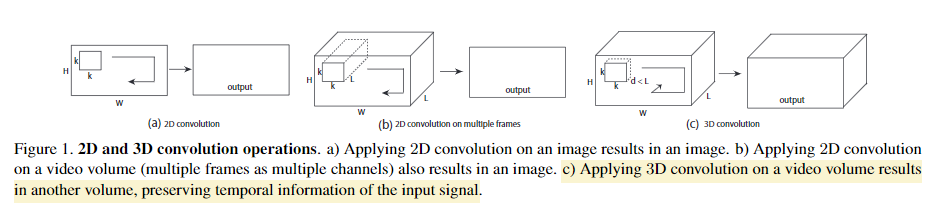
> ### 2D의 경우 모든 결과가 이미지로 나타나기 때문에 3D와 다르게 temporal information의 손실이 일어난다.

> 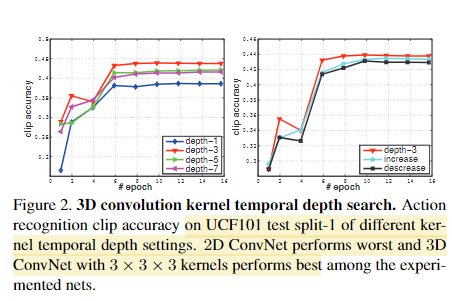
> * 적절한 kernel depth수치를 찾기위해 UCF-101데이터셋으로 depth정보외 나머지는 고정시킨 뒤 실험을 진행
> * 3으로 고정된 것이 가장 좋은 성능을 나타내었다.
> * 3이상의 값은 학습할 파라미터가 더 많은것에도 불구하고 좋지못한 성능을 보여주었다.
> * 1의 경우 2D와 같아서 정보의 손실이 일어나 가장 최악의 성능
> * 실험을 통해 3* 3 * 3 선정(3*3은 2D로부터) 

## 3D ConvNet의 기능
> 아래의 figure들은 컨볼루션 레이어의 feature정보들을 decovolution하여 나타낸 것이다.

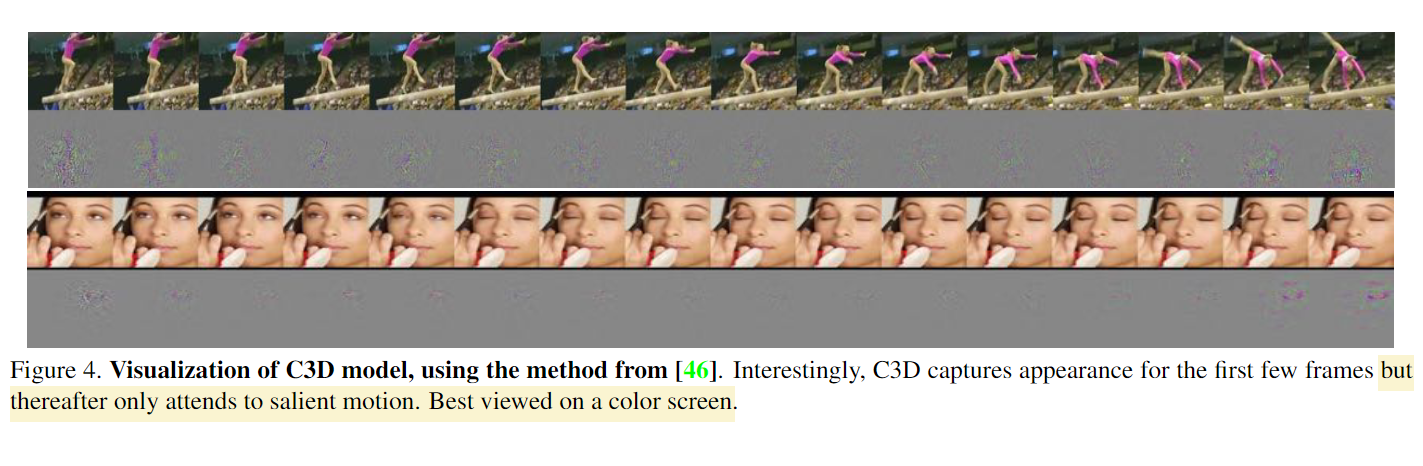
>

> ### deconv연산 결과를 보면 움직이는 요소에 맞춰서 추적하는것을 볼 수 있다.
> ### 따라서 3d convNet은 2D에서의 기능인 외양 뿐만아니라 움직임까지 집중하는것을 확인할 수 있다.

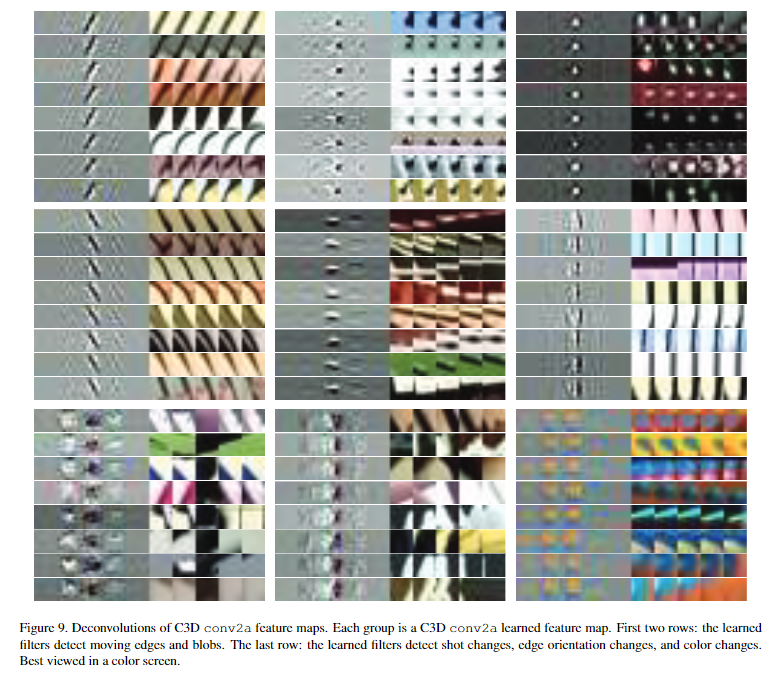

> ### 마찬가지로 conv2a의 featuremap을보면 moving edge와 blobs를 찾을수있다. 
> ### 작은 변화나 edge정렬, 색상변화가 생긴부분또한 볼수있다.

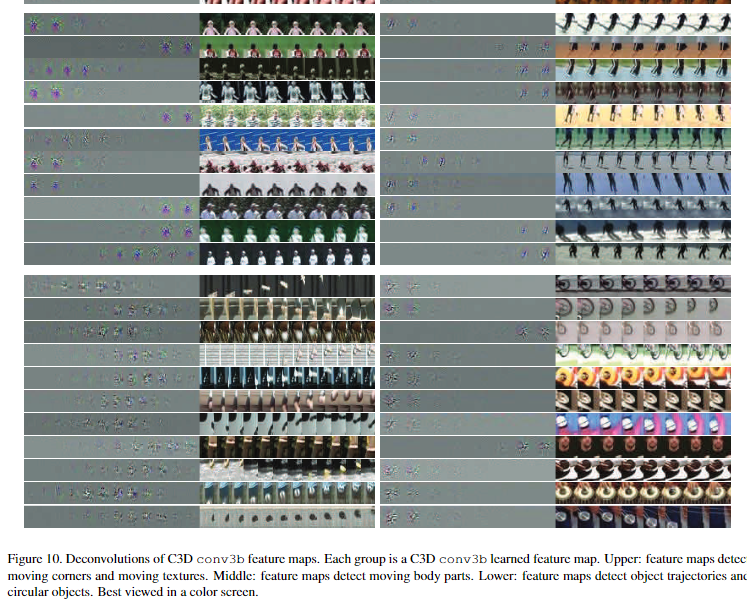

> ### conv3b의 feature map에서도 마찬가지로 움직임 추적 부분이 잘 보인다.

## **네트워크 구조**
> ### C3D의 네트워크 구조는 논문에 나온대로 Conv(3D)레이어와 pooling레이어(maxpool) fc layer를 이용해 구성되었다.
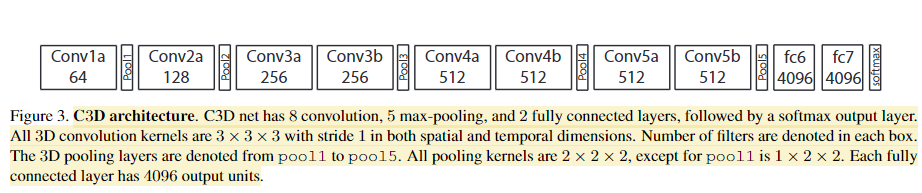

> * ### 첫번째 conv연산 후 pooling에서는 이후의 단계와 다르게 손실을 줄이고자 kernel_size 및 stride를 줄여서 사용하였다.
> * ### fc레이어는 논문에 구현된대로 각 fc레이어는 4096의 output unit을 가진다.
> * ### activation function은 ReLU 사용
> * ### 베이스라인 코드에서는 선형분류기 사용

## C3D_model.py

In [ ]:
import torch
import torch.nn as nn

class C3D(nn.Module):
    """
    The C3D network.
    """

    def __init__(self, num_classes, pretrained=False):
        super(C3D, self).__init__()

        """
        Conv3d
             여러입력평면으로 구성된 입력신호에 3D 컨볼루션작업
             2d와 비교해서 공간적인 정보에대한 성능이 더 좋다. 2D는 연산마다 이전temporal info를 잃어버림(spatio-temporally vs spatially)

        torch.nn.MaxPool3d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        maxpooling연산 
        
        논문에 나온대로의 구조
        """
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)) #논문에서의 실험에의해 3*3커널이 가장 성능이 좋아서 사용
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)) #첫단계에서 손실줄이기(paper)

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        #Each fully connected layer has 4096 output units. (from paper)
        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes) 

        self.dropout = nn.Dropout(p=0.5) #확률 p로 텐서의 일부요소를 무작위로 0으로 변경

        self.relu = nn.ReLU() #activation function

        self.__init_weight()

    def forward(self, x): #논문에 나온 구조대로 만든 레이어 연결, 순전파

        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)

        x = x.view(-1, 8192) #텐서를 한줄로 편다(=reshape)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)

        return logits

    def __init_weight(self): #가중치를 종류에 따라 초기화
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                torch.nn.init.kaiming_normal_(m.weight) #kaiming_normal 방식으로 m.weight를 채운다. 정규분포를 사용하고 샘플링된 값을 갖는다. 
            elif isinstance(m, nn.BatchNorm3d):
                torch.nn.init.constant_(m.weight, 1) #m.weight 텐서를 1로채운다
                torch.nn.init.constant_(m.bias, 0) #m.bias 텐서를 0으로 채운다


## Train.py

> ### 모델훈련
> ### loss function: CrossEntropyLoss
> ### optimizer : SGD 사용, momentum=0.9, weight_decay에 맞춰 감소
> ### epoch = 60 으로 10단위로 모델저장 

In [ ]:
import timeit
from datetime import datetime
import os
import glob
from tqdm import tqdm
import argparse

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

#from dataloaders.dataset import VideoDataset
#from network import C3D_model
import natsort

def train_model(args, dataset, save_dir, saveName, resume_epoch, num_classes, lr, num_epochs, save_epoch, useTest, test_interval):
    """
        Args:
            num_classes (int): Number of classes in the data
            num_epochs (int, optional): Number of epochs to train for.
    """
    model = C3D(num_classes=num_classes, pretrained=False)
    criterion = nn.CrossEntropyLoss()  # standard crossentropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = 5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    if resume_epoch == 0:
        print("Training C3D from scratch...")
    else: #체크포인트에서 가져오기
        checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar'), map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
        print("Initializing weights from: {}...".format(
            os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['opt_dict'])

    #cpu 혹은 gpu사용설정
    print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    model.to(device)
    criterion.to(device)

    #데이터로더 생성, train test가 있고 clip len은 하나의 영상당 16프레임으로
    print('Training model on {} dataset...'.format(dataset))
    train_dataloader = DataLoader(
        VideoDataset(dataset=dataset, split='train',clip_len=16, preprocess=args.preprocess), 
        batch_size=20, shuffle=True, num_workers=args.workers
    )
    train_size = len(train_dataloader.dataset)

    test_dataloader  = DataLoader(
        VideoDataset(dataset=dataset, split='test', clip_len=16, preprocess=args.preprocess), 
        batch_size=20, num_workers=args.workers
    )
    test_size = len(test_dataloader.dataset)
    
    #epoch에 맞춰서 학습 
    for epoch in range(resume_epoch, num_epochs):
        # each epoch has a training and validation step
        start_time = timeit.default_timer()

        # reset the running loss and corrects
        running_loss = 0.0
        running_corrects = 0.0

        model.train()

        for inputs, labels in tqdm(train_dataloader): #input label정보를 데이터로더에서 가져온다.
            # move inputs and labels to the device the training is taking place on
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() #0으로 초기화

            outputs = model(inputs) #모델이 예측한 결과
            loss = criterion(outputs, labels) #손실계산
            loss.backward() #정답과의 차이로 생긴 격차를 역전파 및 가중치 갱신
            optimizer.step() 

            preds = torch.argmax(outputs, dim = 1) #예측한것 분류매칭
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) 
            #print(">>> DBG : ", loss.item() * inputs.size(0), torch.sum(preds == labels.data))

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size

        print("[{}] Epoch: {}/{} Loss: {} Acc: {}".format('train', epoch+1, num_epochs, epoch_loss, epoch_acc))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")

        #설정한 시점마다 모델 가중치상태정보 저장
        if epoch % save_epoch == (save_epoch - 1):
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'opt_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
            print("Save model at {}\n".format(os.path.join(save_dir, 'models', str(num_epochs) + '_epoch-' + str(epoch) + '.pth.tar')))

        #usetest옵션이 있는경우 학습이 끝난 뒤 test진행
        if useTest and epoch % test_interval == (test_interval - 1):
            model.eval()
            start_time = timeit.default_timer()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels, fnames in tqdm(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                preds = torch.argmax(outputs, dim = 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / test_size
            epoch_acc = running_corrects.double() / test_size

            print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, num_epochs, epoch_loss, epoch_acc))
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")
        scheduler.step()
    


In [ ]:
import argparse
#주피터노트북 상에서의 실행을 용이하게 하기위해 argument의 방식변경
if __name__ == "__main__":
    args = argparse.Namespace(
        workers=20,
        preprocess='',
        gpu=0,
        nEpochs=60,
        nTestInterval = 10,
        snapshot = 10,
        lr = 0.005,
        useTest='store_true',
    )
    '''
    parser = argparse.ArgumentParser(description='>>> Start training')

    parser.add_argument('--workers', default= 16, type=int)
    parser.add_argument('--preprocess', action='store_true')
    parser.add_argument('--gpu', default=0, type=int)

    parser.add_argument('--nEpochs', default= 100, type=int)
    parser.add_argument('--nTestInterval', default= 10, type=int)
    parser.add_argument('--snapshot', default= 10, type=int)

    parser.add_argument('--lr', default= 0.005, type=float)
    parser.add_argument('--useTest', action='store_true')
    args = parser.parse_args()
    '''
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device being used:", device)

    dataset = 'ucf101'
    num_classes = 101

    resume_epoch = 0  # Default is 0, change if want to resume
    save_dir_root = "./"  
    if resume_epoch != 0:
        runs = natsort.natsorted(glob.glob(os.path.join(save_dir_root, 'run_*')))
        run_id = int(runs[-1].split('_')[-1]) if runs else 0
    else:
        runs = natsort.natsorted(glob.glob(os.path.join(save_dir_root, 'run_*')))
        run_id = int(runs[-1].split('_')[-1]) + 1 if runs else 0

    save_dir = os.path.join(save_dir_root, 'run_' + str(run_id))
    saveName = 'C3D-' + dataset
    
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    
    if not os.path.exists(save_dir+'/models'):
        os.mkdir(save_dir+'/models')

    train_model(args, dataset, save_dir, saveName, resume_epoch, num_classes, args.lr, args.nEpochs, args.snapshot, args.useTest, args.nTestInterval)


    

Device being used: cuda:0
Training C3D from scratch...
Total params: 78.41M
Training model on ucf101 dataset...
Number of train videos: 9536
Number of test videos: 3782


100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.56it/s]


[train] Epoch: 1/60 Loss: 4.583823580869892 Acc: 0.014261744966442953
Execution time: 133.91770745900067



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 2/60 Loss: 4.368007835525795 Acc: 0.029886744966442953
Execution time: 131.94324526399942



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 3/60 Loss: 4.04902254115015 Acc: 0.06375838926174497
Execution time: 132.49867891800022



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.61it/s]


[train] Epoch: 4/60 Loss: 3.742609786207244 Acc: 0.1050755033557047
Execution time: 131.96007294099945



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 5/60 Loss: 3.4421827491097803 Acc: 0.15551593959731544
Execution time: 131.77042980100032



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 6/60 Loss: 3.1413658436312772 Acc: 0.21413590604026844
Execution time: 131.6191760920001



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 7/60 Loss: 2.865956892553192 Acc: 0.26677852348993286
Execution time: 131.95068334999996



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.63it/s]


[train] Epoch: 8/60 Loss: 2.5872951583974313 Acc: 0.33053691275167785
Execution time: 131.52655400499953



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.61it/s]


[train] Epoch: 9/60 Loss: 2.295199691899271 Acc: 0.39901426174496646
Execution time: 132.21261807700012



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.57it/s]


[train] Epoch: 10/60 Loss: 2.032697570903989 Acc: 0.46193372483221473
Execution time: 133.5162709340002

Save model at ./run_1/models/60_epoch-9.pth.tar



100%|█████████████████████████████████████████| 190/190 [00:23<00:00,  7.99it/s]


[test] Epoch: 10/60 Loss: 3.172651147602854 Acc: 0.27974616604970914
Execution time: 23.796604561000095



100%|█████████████████████████████████████████| 477/477 [02:16<00:00,  3.51it/s]


[train] Epoch: 11/60 Loss: 1.8051849153367865 Acc: 0.520763422818792
Execution time: 136.01814419600032



100%|█████████████████████████████████████████| 477/477 [02:17<00:00,  3.48it/s]


[train] Epoch: 12/60 Loss: 1.58117596360061 Acc: 0.5728817114093959
Execution time: 137.12984537900047



100%|█████████████████████████████████████████| 477/477 [02:14<00:00,  3.56it/s]


[train] Epoch: 13/60 Loss: 1.4380794942579014 Acc: 0.6130453020134228
Execution time: 134.06871068199962



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.57it/s]


[train] Epoch: 14/60 Loss: 1.2408255537934352 Acc: 0.662856543624161
Execution time: 133.49622955199993



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.58it/s]


[train] Epoch: 15/60 Loss: 1.0979493074869149 Acc: 0.6945260067114094
Execution time: 133.37802706299954



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.61it/s]


[train] Epoch: 16/60 Loss: 0.982037877676471 Acc: 0.7264052013422818
Execution time: 132.00870662800025



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.61it/s]


[train] Epoch: 17/60 Loss: 0.898171095777578 Acc: 0.7519924496644295
Execution time: 131.96330006399967



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.61it/s]


[train] Epoch: 18/60 Loss: 0.8371435688783558 Acc: 0.7671979865771812
Execution time: 131.96713739200004



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.58it/s]


[train] Epoch: 19/60 Loss: 0.7197819880691151 Acc: 0.7958263422818792
Execution time: 133.2166256089995



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 20/60 Loss: 0.6846499497027155 Acc: 0.8072567114093959
Execution time: 132.84468822399958

Save model at ./run_1/models/60_epoch-19.pth.tar



100%|█████████████████████████████████████████| 190/190 [00:23<00:00,  8.09it/s]


[test] Epoch: 20/60 Loss: 3.4657569156318413 Acc: 0.32152300370174514
Execution time: 23.488850552999793



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 21/60 Loss: 0.37705769535308803 Acc: 0.8890520134228188
Execution time: 132.56349390200012



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 22/60 Loss: 0.2726384088800964 Acc: 0.920511744966443
Execution time: 132.92249224100033



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.58it/s]


[train] Epoch: 23/60 Loss: 0.2365932853862365 Acc: 0.9315226510067114
Execution time: 133.17204296399905



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.57it/s]


[train] Epoch: 24/60 Loss: 0.1982212073349155 Acc: 0.9412751677852349
Execution time: 133.44068306700137



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 25/60 Loss: 0.1922781251838912 Acc: 0.9421140939597316
Execution time: 132.80331724499956



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.59it/s]


[train] Epoch: 26/60 Loss: 0.17645478050553415 Acc: 0.9456795302013422
Execution time: 133.0382389339993



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.58it/s]


[train] Epoch: 27/60 Loss: 0.16364389827787282 Acc: 0.9493498322147651
Execution time: 133.25501046799945



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 28/60 Loss: 0.16444389284483896 Acc: 0.9501887583892618
Execution time: 132.63453737800046



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 29/60 Loss: 0.1437005085432406 Acc: 0.9563758389261745
Execution time: 132.70430546100033



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 30/60 Loss: 0.12322915082748771 Acc: 0.9620385906040269
Execution time: 132.94009061399993

Save model at ./run_1/models/60_epoch-29.pth.tar



100%|█████████████████████████████████████████| 190/190 [00:22<00:00,  8.27it/s]


[test] Epoch: 30/60 Loss: 3.9360889370387224 Acc: 0.38286620835536755
Execution time: 22.967659787998855



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.61it/s]


[train] Epoch: 31/60 Loss: 0.12777156290188782 Acc: 0.9579488255033557
Execution time: 132.05652481699872



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 32/60 Loss: 0.1274638748504821 Acc: 0.9614093959731543
Execution time: 132.837896078001



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 33/60 Loss: 0.12173879668874929 Acc: 0.9616191275167785
Execution time: 131.7896117629989



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 34/60 Loss: 0.11916093115938785 Acc: 0.9638213087248322
Execution time: 131.799788196



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.61it/s]


[train] Epoch: 35/60 Loss: 0.10469463200047815 Acc: 0.9685402684563759
Execution time: 132.02546120899933



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 36/60 Loss: 0.0966938000602879 Acc: 0.9710570469798657
Execution time: 132.62175646200012



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 37/60 Loss: 0.1008968678692992 Acc: 0.9706375838926175
Execution time: 131.68458013599957



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 38/60 Loss: 0.09232636712196177 Acc: 0.9707424496644295
Execution time: 131.8408199080004



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.63it/s]


[train] Epoch: 39/60 Loss: 0.09561869145850842 Acc: 0.970113255033557
Execution time: 131.55007360999844



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 40/60 Loss: 0.08545251869775287 Acc: 0.9712667785234899
Execution time: 131.6095011689995

Save model at ./run_1/models/60_epoch-39.pth.tar



100%|█████████████████████████████████████████| 190/190 [00:23<00:00,  8.18it/s]


[test] Epoch: 40/60 Loss: 4.037286441637246 Acc: 0.3939714436805923
Execution time: 23.22305009899901



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.63it/s]


[train] Epoch: 41/60 Loss: 0.0747880592404464 Acc: 0.9774538590604027
Execution time: 131.3797982849992



100%|█████████████████████████████████████████| 477/477 [02:11<00:00,  3.62it/s]


[train] Epoch: 42/60 Loss: 0.07513435859354312 Acc: 0.9775587248322147
Execution time: 131.82244683299905



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.61it/s]


[train] Epoch: 43/60 Loss: 0.07613294514020091 Acc: 0.9776635906040269
Execution time: 132.0809312780002



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.61it/s]


[train] Epoch: 44/60 Loss: 0.06628291579553411 Acc: 0.9799706375838926
Execution time: 132.23396341999978



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 45/60 Loss: 0.0700563687775788 Acc: 0.9786073825503355
Execution time: 132.68082641899855



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 46/60 Loss: 0.07372320411260085 Acc: 0.9770343959731543
Execution time: 132.45877243799987



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.58it/s]


[train] Epoch: 47/60 Loss: 0.06798948819308459 Acc: 0.979236577181208
Execution time: 133.16601775399977



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 48/60 Loss: 0.06515268256516231 Acc: 0.9813338926174496
Execution time: 132.981583064



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 49/60 Loss: 0.06339056857701361 Acc: 0.9793414429530201
Execution time: 132.89327571300055



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.58it/s]


[train] Epoch: 50/60 Loss: 0.05631355232243635 Acc: 0.9829068791946308
Execution time: 133.22380004299885

Save model at ./run_1/models/60_epoch-49.pth.tar



100%|█████████████████████████████████████████| 190/190 [00:23<00:00,  8.18it/s]


[test] Epoch: 50/60 Loss: 4.1470644137088755 Acc: 0.40401903754627183
Execution time: 23.228585709999606



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 51/60 Loss: 0.06887387502443505 Acc: 0.9790268456375839
Execution time: 132.7803278169995



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 52/60 Loss: 0.06434107275813228 Acc: 0.9795511744966443
Execution time: 132.4220433850005



100%|█████████████████████████████████████████| 477/477 [02:14<00:00,  3.56it/s]


[train] Epoch: 53/60 Loss: 0.05937969032302685 Acc: 0.9811241610738255
Execution time: 134.01324697100063



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.57it/s]


[train] Epoch: 54/60 Loss: 0.060286941368050496 Acc: 0.9807046979865771
Execution time: 133.54280813399964



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 55/60 Loss: 0.0629848025205289 Acc: 0.9789219798657718
Execution time: 132.3755735169998



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.60it/s]


[train] Epoch: 56/60 Loss: 0.06545139348792335 Acc: 0.9798657718120806
Execution time: 132.34636164999938



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.59it/s]


[train] Epoch: 57/60 Loss: 0.06202712237950894 Acc: 0.9802852348993288
Execution time: 132.96055656099998



100%|█████████████████████████████████████████| 477/477 [02:12<00:00,  3.61it/s]


[train] Epoch: 58/60 Loss: 0.06806308722912036 Acc: 0.9795511744966443
Execution time: 132.0329279230009



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.58it/s]


[train] Epoch: 59/60 Loss: 0.0628148825863175 Acc: 0.9813338926174496
Execution time: 133.21175975699953



100%|█████████████████████████████████████████| 477/477 [02:13<00:00,  3.56it/s]


[train] Epoch: 60/60 Loss: 0.06612479477703437 Acc: 0.9787122483221476
Execution time: 133.87235842600057

Save model at ./run_1/models/60_epoch-59.pth.tar



100%|█████████████████████████████████████████| 190/190 [00:23<00:00,  8.16it/s]

[test] Epoch: 60/60 Loss: 4.1692704420865745 Acc: 0.4032258064516129
Execution time: 23.282612503000564



## evaluation.py

In [ ]:
from datetime import datetime
import os
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import json
import argparse

import torch
from torch import nn
from torch.utils.data import DataLoader

#from dataloaders.dataset import VideoDataset
#from network import C3D_model


def evaluation(args):
    model = C3D(num_classes=101, pretrained=False)
    criterion = nn.CrossEntropyLoss()  # standard crossentropy loss for classification
    checkpoint = torch.load(args.trained_model_path,map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
   
    print("Initializing weights from: {}...".format(args.trained_model_path))
    model.load_state_dict(checkpoint['state_dict'])

    print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    model.to(device)
    criterion.to(device)

    test_dataloader  = DataLoader(VideoDataset(dataset='ucf101', split='test', clip_len=16, preprocess=False), batch_size=20, num_workers=args.workers)

    model.eval()

    result = dict()
    total_preds = list()
    total_labels = list()
    
    for inputs, labels, test_vid_name in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
        preds = torch.argmax(outputs, dim = 1)

        total_preds.extend(np.asarray(preds.to('cpu')))
        total_labels.extend(np.asarray(labels.to('cpu')))


    total_preds = [ int(i) for i in total_preds ]
    total_labels = [ int(i) for i in total_labels ]

    print("[Result] : Acc: {}".format(accuracy_score(total_labels, total_preds)))
    with open('./submit.json', 'w') as f:
        json.dump({'preds' : total_preds, 'labels' : total_labels}, f)

if __name__ == "__main__":

    args = argparse.Namespace(
        workers=20,
        gpu=0,
        trained_model_path= '/home/hyeonji/CV_endTerm_C3D/run_1/models/C3D-ucf101_epoch-59.pth.tar'
    )



    """parser = argparse.ArgumentParser(description='>>> Start training')

    parser.add_argument('--workers', default= 16, type=int) #20
    parser.add_argument('--gpu', default=0, type=int)
    parser.add_argument('--trained_model_path', default='/path/to/model', type=str, required=True)

    args = parser.parse_args()"""

    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device being used:", device)

    evaluation(args)

Device being used: cuda:0
Initializing weights from: /home/hyeonji/CV_endTerm_C3D/run_1/models/C3D-ucf101_epoch-59.pth.tar...
Total params: 78.41M
Number of test videos: 3782


100%|█████████████████████████████████████████| 190/190 [00:23<00:00,  8.16it/s]

[Result] : Acc: 0.40058170280274985
